In [ ]:
import sys
sys.path.append("../src")
from utils.common.pathManager import FilePath
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cv2 import imread
import pandas as pd
import sys
sys.path.append("../src")
from utils.common.pathManager import FilePath
from collections import defaultdict
from shapely import wkt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cv2 import imread
import pandas as pd
from utils.visualization.label_to_color import LabelDict
xbd_path = FilePath("/media/mrtc101/Martín SSD/tesis/datasets/xBD")

# Input Data Análisis

In [ ]:
from preprocessing.prepare_folder.create_label_masks import create_masks
from utils.visualization.label_to_color import LabelDict

def count_pxls(mask_path):
    row = np.zeros(6,np.uint16)
    count_tup = np.unique(imread(mask_path)[:,:,0],return_counts=True)
    for l,c in zip(count_tup[0],count_tup[1]):
        row[l] = c
    return list(row)

def count_blds(json_path):
    label_dict = json_path.read_json()
    label_count = pd.Series(data=np.zeros(6, dtype=np.uint16), index=LabelDict.labels.keys())
    for building in label_dict['features']['xy']:
        dmg_label = building['properties'].get('subtype')
        if dmg_label in label_count.index:
            label_count[dmg_label] += 1
    row = label_count.tolist()
    return list(row)

#create_masks(xbd_path)
splits_dict = FilePath("/home/mrtc101/Desktop/tesina/repo/main/fakedata/data/splits/raw_splits.json").read_json()
px_rows = []
bld_rows = []
for split_id, dis_dict in splits_dict.items():
    for dis_id, tile_dict in dis_dict.items():
        for tile_id in tile_dict.keys():
            imgs_dict = tile_dict[tile_id]["post"]
            mask_path = FilePath(imgs_dict["mask"])
            json_path = FilePath(imgs_dict["json"])
            px_count = count_pxls(mask_path)
            bld_count = count_blds(json_path)
            px_rows.append([split_id,dis_id,tile_id]+px_count)
            bld_rows.append([split_id,dis_id,tile_id]+bld_count)

In [ ]:
bld_Count_df  = pd.DataFrame(bld_rows,columns=["split_id","dis_id","tile_id"]+list(LabelDict().labels.keys()))
bld_Count_df

,split_id,dis_id,tile_id,background,no-damage,minor-damage,major-damage,destroyed,un-classified
0,train,socal-fire,00000756,0,12,0,0,2,5
1,train,socal-fire,00000605,0,10,0,0,0,0
2,train,socal-fire,00001224,0,13,0,0,0,0
3,train,socal-fire,00000854,0,9,0,0,0,3
4,train,socal-fire,00001018,0,12,0,0,0,2
...,...,...,...,...,...,...,...,...,...
1103,test,tuscaloosa-tornado,00000266,0,22,12,3,3,15
1104,test,joplin-tornado,00000066,0,13,3,0,0,0
1105,test,joplin-tornado,00000016,0,10,30,25,94,0
1106,test,joplin-tornado,00000088,0,11,8,4,65,7


In [ ]:
px_Count_df  = pd.DataFrame(px_rows,columns=["split_id","dis_id","tile_id"]+list(LabelDict().labels.keys()))
px_Count_df

,split_id,dis_id,tile_id,background,no-damage,minor-damage,major-damage,destroyed,un-classified
0,train,socal-fire,00000756,56640,7628,0,0,1268,0
1,train,socal-fire,00000605,16673,48863,0,0,0,0
2,train,socal-fire,00001224,48983,16553,0,0,0,0
3,train,socal-fire,00000854,49491,16045,0,0,0,0
4,train,socal-fire,00001018,58331,7205,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1103,test,tuscaloosa-tornado,00000266,46207,9786,5840,2241,1462,0
1104,test,joplin-tornado,00000066,54767,63936,12369,0,0,0
1105,test,joplin-tornado,00000016,1705,6707,24766,23080,9278,0
1106,test,joplin-tornado,00000088,385,4074,8784,10943,41350,0


# Bld count per disaster

In [ ]:
bld_matrix = bld_Count_df.drop(columns=["background"]).groupby(["split_id","dis_id"]).apply(lambda x: x.sum(axis=0,numeric_only=True),include_groups=False)
bld_matrix["Total"] = bld_matrix.sum(axis=1)

test_total_s = bld_matrix.loc["test"].sum(axis=0)
bld_matrix.loc[("test","Total"),:] = test_total_s

train_total_s = bld_matrix.loc["test"].sum(axis=0)
bld_matrix.loc[("train","Total"),:] = train_total_s

total = bld_matrix.sum(axis=0)
bld_matrix.loc[("Total","-"),:] = total
bld_matrix = bld_matrix.astype(int)
bld_matrix

no-damage  minor-damage  major-damage  \
split_id dis_id                                                       
test     hurricane-florence          55             0             0   
         hurricane-harvey           122           198          1111   
         hurricane-matthew           11           322            35   
         hurricane-michael          181           126            43   
         joplin-tornado              35            45            49   
         lower-puna-volcano          34             0             0   
         midwest-flooding            65             1             5   
         moore-tornado               25            28            24   
         nepal-flooding             107            39           107   
         palu-tsunami               475             0            70   
         pinery-bushfire             78             1             0   
         portugal-wildfire          112             1             2   
         santa-rosa-wildfire         22             2             0   
         socal-fire                  65             0             0   
         sunda-tsunami               10             0             0   
         tuscaloosa-tornado          95           122             4   
         woolsey-fire               116             4             1   
train    guatemala-volcano           42             2             0   
         hurricane-florence         593             9             8   
         hurricane-harvey           698          1722          8125   
         hurricane-matthew          657          8235          1185   
         hurricane-michael          882           673           213   
         joplin-tornado             556           563           400   
         lower-puna-volcano         243            10             0   
         mexico-earthquake           40             0             0   
         midwest-flooding           516            30            13   
         moore-tornado              426           186           159   
         nepal-flooding             477           418           776   
         palu-tsunami              1225             1           190   
         pinery-bushfire            731             9            15   
         portugal-wildfire         1290            14            28   
         santa-rosa-wildfire       1012            35            35   
         socal-fire                1216            15            21   
         sunda-tsunami              122             0             1   
         tuscaloosa-tornado         375           149            38   
         woolsey-fire               775            24            17   
test     Total                     1608           889          1451   
train    Total                     3216          1778          2902   
Total    -                        18308         15651         17028   

                              destroyed  un-classified  Total  
split_id dis_id                                                
test     hurricane-florence           0              2     57  
         hurricane-harvey            18              4   1453  
         hurricane-matthew          150              6    524  
         hurricane-michael           12              4    366  
         joplin-tornado             514              7    650  
         lower-puna-volcano           1              8     43  
         midwest-flooding             1             11     83  
         moore-tornado              197             11    285  
         nepal-flooding               0              5    258  
         palu-tsunami               702             72   1319  
         pinery-bushfire              1             10     90  
         portugal-wildfire            1              7    123  
         santa-rosa-wildfire        351              5    380  
         socal-fire                  75             10    150  
         sunda-tsunami                0              2     12  
         tuscaloosa-tornado   

# pixel count by disaster

In [ ]:
px_matrix = px_Count_df.groupby(["split_id","dis_id"]).apply(lambda x: x.sum(axis=0,numeric_only=True),include_groups=False)
px_matrix["Total"] = px_matrix.sum(axis=1)
test_total_s = px_matrix.loc["test"].sum(axis=0)
px_matrix.loc[("test","Total"),:] = test_total_s

train_total_s = px_matrix.loc["test"].sum(axis=0)
px_matrix.loc[("train","Total"),:] = train_total_s

total = px_matrix.sum(axis=0)
px_matrix.loc[("Total","-"),:] = total
px_matrix = px_matrix.astype(int)
px_matrix

background  no-damage  minor-damage  \
split_id dis_id                                                     
test     hurricane-florence       258301      69379             0   
         hurricane-harvey         286164      98705        170146   
         hurricane-matthew        114304       7063         67779   
         hurricane-michael        166312     175226        117279   
         joplin-tornado           111802      76013         49792   
         lower-puna-volcano       184520      11982             0   
         midwest-flooding         349296      38753          1749   
         moore-tornado             63905      34053         31600   
         nepal-flooding            71588      21611         11275   
         palu-tsunami             259368     202780             0   
         pinery-bushfire          417864      40431           248   
         portugal-wildfire        583515      70044           764   
         santa-rosa-wildfire      156105      33112          2870   
         socal-fire               289708      51607             0   
         sunda-tsunami             58244       7292             0   
         tuscaloosa-tornado       126477     107883         22882   
         woolsey-fire             490383      74003          3370   
train    guatemala-volcano        212760      48905           479   
         hurricane-florence      3052497     526758         10045   
         hurricane-harvey        2480539     729489       1237797   
         hurricane-matthew       1363037     272334        949419   
         hurricane-michael       1097755     765552        521611   
         joplin-tornado           822572     292755        447625   
         lower-puna-volcano      1267603     117985          6081   
         mexico-earthquake        174980      87164             0   
         midwest-flooding        2755421     355927         14414   
         moore-tornado            831283     356226        192291   
         nepal-flooding           902949     214589        143378   
         palu-tsunami            1097301     427125           833   
         pinery-bushfire         3979334     445279          6163   
         portugal-wildfire       6402054     849765          4816   
         santa-rosa-wildfire     2332776     976984         53978   
         socal-fire              4580103    1271415         11476   
         sunda-tsunami            580193     139004             0   
         tuscaloosa-tornado      1071604     455114        149060   
         woolsey-fire            3056010     546249         13555   
test     Total                   3987856    1119937        479754   
train    Total                   7975712    2239874        959508   
Total    -                      54012195   13358367       5682037   

                              major-damage  destroyed  un-classified     Total  
split_id dis_id                                                                 
test     hurricane-florence              0          0              0    327680  
         hurricane-harvey           338053      24436              0    917504  
         hurricane-matthew           22958      50040              0    262144  
         hurricane-michael           56367       9104              0    524288  
         joplin-tornado              50910     104699              0    393216  
         lower-puna-volcano              0        106              0    196608  
         midwest-flooding             3361         57              0    393216  
         moore-tornado               25814      41236              0    196608  
         nepal-flooding              26598          0              0    131072  
         palu-tsunami                90220     168528              0    720896  
         pinery-bushfire                 0        209              0    458752  
         portugal-wildfire             830        207              0    655360  
         santa-rosa-wildfire             0      70057             

# Predicted weights

In [ ]:
pxsum = px_matrix.loc[("Total","-")][:5]
weights = pxsum.sum() / pxsum
weights

background       1.591923
no-damage        6.436657
minor-damage    15.132466
major-damage    12.907077
destroyed       13.715794
Name: (Total, -), dtype: float64

# distribution of buildings per tile

array([[<Axes: title={'center': 'no-damage'}>,
        <Axes: title={'center': 'minor-damage'}>],
       [<Axes: title={'center': 'major-damage'}>,
        <Axes: title={'center': 'destroyed'}>]], dtype=object)

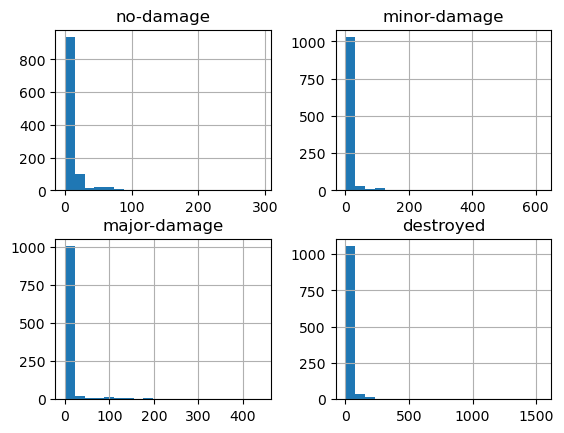

In [ ]:
bld_Count_df.set_index(["split_id","dis_id","tile_id"]).drop(columns=["background","un-classified"]).hist(bins=20)

# distribution of pixels per tile

array([[<Axes: title={'center': 'no-damage'}>,
        <Axes: title={'center': 'minor-damage'}>],
       [<Axes: title={'center': 'major-damage'}>,
        <Axes: title={'center': 'destroyed'}>]], dtype=object)

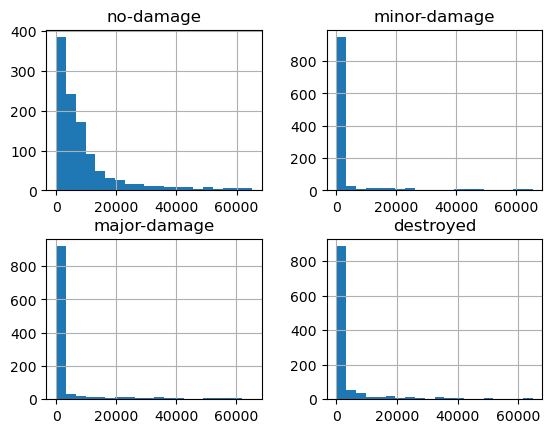

In [ ]:
px_Count_df.set_index(["split_id","dis_id","tile_id"]).drop(columns=["background","un-classified"]).hist(bins=20)

# Disaster Sum

In [ ]:
bld_Count_df.value_counts("split_id")

split_id
train    998
test     110
Name: count, dtype: int64

In [ ]:
bld_matrix["Total"]


split_id  dis_id             
test      hurricane-florence        57
          hurricane-harvey        1453
          hurricane-matthew        524
          hurricane-michael        366
          joplin-tornado           650
          lower-puna-volcano        43
          midwest-flooding          83
          moore-tornado            285
          nepal-flooding           258
          palu-tsunami            1319
          pinery-bushfire           90
          portugal-wildfire        123
          santa-rosa-wildfire      380
          socal-fire               150
          sunda-tsunami             12
          tuscaloosa-tornado       242
          woolsey-fire             159
train     guatemala-volcano         44
          hurricane-florence       643
          hurricane-harvey       11042
          hurricane-matthew      10869
          hurricane-michael       1875
          joplin-tornado          3171
          lower-puna-volcano       450
          mexico-earthquake       

# Results data análisis

In [ ]:

def build_weights_table(out_path: FilePath) -> pd.DataFrame:
    w_json = out_path.join("train_weights.json")
    w_dict = w_json.read_json()
    w_dict = w_dict.get("dmg", w_dict)
    w_row = [[cls_name, round(wei)] for cls_name, wei in w_dict.items()]
    return pd.DataFrame(w_row, columns=["Class", "Weight"])


def build_conf_table(out_path: FilePath):
    conf_json = out_path.join("conf_list.json")
    conf_list: dict = conf_json.read_json()
    rows = []
    for i, param_dict in conf_list:
        row = [f"Config {i}", param_dict["batch_size"],
               param_dict["learning_rate"], param_dict["tot_epochs"]]
        rows.append(row)
    return pd.DataFrame(rows, columns=["Number", "Batch size", "Learning rate", "Total epochs"])


def load_dfs(metric_dir: FilePath) -> tuple[pd.DataFrame]:
    bld_df = pd.read_csv(metric_dir.join("val_bld_pixel_level.csv"))
    bld_df = bld_df.set_index(["epoch", "class"])
    dmg_df = pd.read_csv(metric_dir.join("val_dmg_pixel_level.csv"))
    dmg_df = dmg_df.set_index(["epoch", "class"])
    loss_df = pd.read_csv(metric_dir.join("val_loss.csv"))
    loss_df = loss_df.set_index(["epoch"])
    return bld_df, dmg_df, loss_df


def build_fold_table(out_path: FilePath):
    config_folders = [fol_name for fol_name in out_path.get_folder_names()
                      if fol_name.startswith("config")]
    fold_list = []
    for dir in config_folders:
        conf_path = out_path.join(dir)
        for fold in conf_path.get_folder_names():
            fold_dir = conf_path.join(fold)
            metric_dir = fold_dir.join("metrics/csv")
            bld_df, dmg_df, loss_df = load_dfs(metric_dir)
            c = dir[len(dir)-1]
            f = fold[len(fold)-1]
            best_f1_hm = dmg_df["f1_harmonic_mean"].max()
            best_epoch = dmg_df["f1_harmonic_mean"].idxmax()[0]
            val_loss = loss_df.loc[best_epoch].iloc[0]
            seg_f1 = bld_df.loc[best_epoch]["f1"].iloc[0]
            dmg_f1 = dmg_df.loc[best_epoch, 0]["f1"]
            seg_hf1 = 2 / ((1 / seg_f1) + (1 / dmg_f1))
            row = [f"C{c}", f"F{f}", best_epoch, val_loss, best_f1_hm, seg_hf1]
            fold_list.append(row)

    fold_df = pd.DataFrame(fold_list, columns=[
                           "Conf", "Fold", "Best epoch", "val-loss", "HMf1-dmg", "HFM1-seg"])
    fold_df = fold_df.sort_values(by=["Conf"])
    fold_df = round(fold_df, 4)
    fold_df = fold_df.groupby("Conf").apply(lambda x: x.set_index("Fold"), include_groups=False)
    fold_df = fold_df.sort_values(["Conf","Fold"])
    return fold_df


def plot_loss(tr_l: pd.DataFrame, vl_l: pd.DataFrame, step):
    # Renombrar las columnas para evitar confusiones
    tr_l = tr_l.rename(columns={"loss": "train_loss"})
    vl_l = vl_l.rename(columns={"loss": "val_loss"})
    f_df = pd.concat([tr_l, vl_l], axis=1)

    # Crear la figura y el eje, ajustando el tamaño
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    # Graficar las pérdidas de entrenamiento y validación
    ax.plot(f_df.index, f_df["train_loss"], label="Train Loss", linewidth=2)
    ax.plot(f_df.index, f_df["val_loss"], label="Validation Loss", linestyle='--', linewidth=2)

    # Título y etiquetas con fuentes más grandes
    # ax.set_title("Pérdida a lo largo de las épocas", fontsize=24)
    ax.set_xlabel('Epoch', fontsize=24)
    ax.set_ylabel('Loss', fontsize=24)

    # Aumentar el tamaño de la leyenda
    ax.legend(fontsize=24, loc="upper right", fancybox=True, framealpha=1, shadow=True, borderpad=1)

    ax.set_xticks(range(0, f_df.index.max()+1, step))

    # Añadir cuadrícula
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.show()


def plot_harmonic_mean(tr_m: pd.DataFrame, vl_m: pd.DataFrame, step):
    # Filtrar y procesar los datos de entrenamiento y validación para la clase 0
    tr = tr_m[tr_m["class"] == 0][["epoch", "f1_harmonic_mean"]]
    tr = tr.rename(columns={"f1_harmonic_mean": "f1_h_train"})
    tr = tr.set_index("epoch")


    vl = vl_m[vl_m["class"] == 0][["epoch", "f1_harmonic_mean"]]
    vl = vl.rename(columns={"f1_harmonic_mean": "f1_h_val"})
    vl = vl.set_index("epoch")

    # Concatenar los datos de entrenamiento y validación
    metrics_df = pd.concat([tr, vl], axis=1)

    # Crear la figura y el eje
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    # Graficar cada conjunto de datos por separado
    ax.plot(metrics_df.index, metrics_df['f1_h_train'],
            label='HMF1 de Entrenamiento', color='blue', linewidth=2)
    ax.plot(metrics_df.index, metrics_df['f1_h_val'],
            label='HMF1 de Validación', color='orange', linestyle='--', linewidth=2)

    # Configuración de título y etiquetas en español
    # ax.set_title('Media Armónica del F1 a lo largo de las Épocas', fontsize=18)
    ax.set_xlabel('Epoch', fontsize=20)
    ax.set_ylabel('F1 Harmonic Mean', fontsize=20)

    # Asegurar que el eje X use números enteros
    ax.set_xticks(range(0, tr_m["epoch"].max()+1, step))

    # Aumentar el tamaño de la leyenda y configurarla adecuadamente
    ax.legend(fontsize=20, loc="lower right", fancybox=True, framealpha=1, shadow=True, borderpad=1)

    # Aumentar el tamaño de las marcas en los ejes
    ax.tick_params(axis='both', which='major', labelsize=20)

    # Mostrar cuadrícula
    ax.grid(True)

    # Mostrar la gráfica
    plt.show()


def plot_metric_per_class(tr_m: pd.DataFrame, metric: str, step):
    
    # Convertir números de clase en nombres de clase
    tr_m['class'] = tr_m['class'].apply(lambda x: LabelDict().get_key_by_num(int(x)))

    # Pivotar los datos para tener épocas como índice y clases como columnas
    tr = tr_m.pivot(index='epoch', columns='class', values=metric)

    # puedes personalizar estos colores
    colors = ['#0f0f0f', '#ff1e1e', '#2ca02c', '#ffa500', '#808080']

    # Crear la figura y el eje con un DPI mejorado para mayor calidad
    fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

    # Graficar cada clase con un color y estilo de línea diferente
    for i, col in enumerate(tr.columns):
        ax.plot(tr.index, tr[col], label=col, linewidth=2, color=colors[i % len(colors)])

    # Configuración de título y etiquetas en español
    # ax.set_title(f'{metric.capitalize()} por Clase a lo Largo de las Épocas', fontsize=18)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel(f'{metric.capitalize()}', fontsize=14)

    # Configuración de la leyenda
    ax.legend(fontsize=14, loc='best', fancybox=True, framealpha=1, shadow=True, borderpad=1)

    # Asegurar que el eje X use números enteros
    ax.set_xticks(range(0, tr_m["epoch"].max()+1, step))

    # Aumentar el tamaño de las marcas en los ejes
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Mostrar cuadrícula
    ax.grid(True)

    # Mostrar la gráfica
    plt.tight_layout()  # Ajustar automáticamente el diseño para que no se solapen elementos
    plt.show()


def load_metric_dfs(split, metric_dir: FilePath) -> tuple[pd.DataFrame]:
    bld_df = pd.read_csv(metric_dir.join(f"{split}_bld_pixel_level.csv"))
    bld_df = bld_df.set_index(["epoch", "class"])
    dmg_df = pd.read_csv(metric_dir.join(f"{split}_dmg_pixel_level.csv"))
    dmg_df = dmg_df.set_index(["epoch", "class"])
    loss_df = pd.read_csv(metric_dir.join(f"{split}_loss.csv"))
    loss_df = loss_df.set_index(["epoch"])
    return bld_df, dmg_df, loss_df


def build_subtable(split, best_epoch, bld_df, dmg_df, loss_df):
    # Computing hf1 for segmentation
    seg_f1 = bld_df.loc[best_epoch]["f1"].iloc[0]
    dmg_f1 = dmg_df.loc[best_epoch, 0]["f1"]
    seg_hf1 = 2 / ((1 / seg_f1) + (1 / dmg_f1))

    # Segmentation sub sub table
    seg_sub = pd.concat([dmg_df.loc[best_epoch].loc[[0]], bld_df.loc[best_epoch]])
    seg_sub.reset_index(inplace=True)
    seg_sub["class"] = ["background", "building"]
    seg_sub.set_index("class", inplace=True)
    seg_sub["hf1"] = seg_hf1
    seg_sub = seg_sub.groupby(["hf1"]).apply(lambda x: x, include_groups=False)
    seg_sub.drop(columns=["f1_harmonic_mean"], inplace=True)

    # Classification sub sub table
    dmg_hf1 = dmg_df.loc[best_epoch]["f1_harmonic_mean"].iloc[0].copy()
    dmg_sub = dmg_df.loc[best_epoch].copy()
    dmg_sub["hf1"] = dmg_hf1
    dmg_sub.reset_index(inplace=True)
    dmg_sub["class"] = dmg_sub["class"].apply(LabelDict().get_key_by_num)
    dmg_sub.set_index("class", inplace=True)
    dmg_sub = dmg_sub.groupby(["hf1"]).apply(lambda x: x, include_groups=False)
    dmg_sub.drop(columns=["f1_harmonic_mean"], inplace=True)

    subtable = pd.concat([seg_sub, dmg_sub])
    subtable["split"] = split
    subtable = subtable.groupby(["split"]).apply(lambda x: x, include_groups=False)
    subtable = round(subtable, 4)
    loss = loss_df.loc[best_epoch].iloc[0]
    loss = round(loss, 4)
    return subtable, loss


def build_val_test_table(path, fold_df, test_path = None):
    best_conf = fold_df["HMf1-dmg"].idxmax() if len(fold_df > 0) else 0
    val_metric_dir = path.join("definitive_model/metrics/csv/")
    val_bld_df, val_dmg_df, val_loss_df = load_metric_dfs('val', val_metric_dir)
    best_epoch = val_dmg_df["f1_harmonic_mean"].idxmax()[0]
    val_sub, val_loss = build_subtable(
        "validation", best_epoch, val_bld_df, val_dmg_df, val_loss_df)

    if test_path:
        test_metric_dir = path.join(test_path)
        test_bld_df, test_dmg_df, test_loss_df = load_metric_dfs('test', test_metric_dir)
        test_sub, test_loss = build_subtable("test", best_epoch, test_bld_df, test_dmg_df, test_loss_df)
        table = pd.concat([val_sub, test_sub])
        header = f"Mejor configuración = {best_conf} & Mejor época = {best_epoch} & val_loss = {val_loss} & test_loss = {test_loss}"
    else:
        header = f"Mejor configuración = {best_conf} & Mejor época = {best_epoch} & val_loss = {val_loss} \\\\"
        table = val_sub
    return header, table

# Experiment 1

In [ ]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp1_mendieta/out")


In [ ]:
wei_df = build_weights_table(path)
wei_df

,Class,Weight
0,destroyed,15432
1,major-damage,890
2,minor-damage,230
3,no-damage,1


In [ ]:
params_df = build_conf_table(path)
params_df

,Number,Batch size,Learning rate,Total epochs
0,Config 0,16,0.0010,20
1,Config 1,16,0.0001,20
2,Config 2,32,0.0010,20
3,Config 3,32,0.0001,20


In [ ]:
fold_df = build_fold_table(path)
fold_df

Best epoch  val-loss  HMf1-dmg  HFM1-seg
Conf Fold                                          
C0   F0            15    0.1173    0.0219    0.0201
     F1            17    0.1177    0.0258    0.0142
C1   F0            18    0.1188    0.0178    0.0122
     F1            20    0.1239    0.0093    0.0269
C2   F0             7    0.0656    0.0174    0.0107
     F1             6    0.0642    0.0187    0.0122
C3   F0            13    0.0638    0.0211    0.0153
     F1            19    0.0701    0.0279    0.0178

In [ ]:
test_path = FilePath("definitive_model/best_metrics/csv/")
header, table = build_val_test_table(path, fold_df)
print(header)
table

Mejor configuración = ('C3', 'F1') & Mejor época = 18 & val_loss = 0.1037 \\


precision  recall      f1  accuracy
split      hf1      class                                            
validation 0.017500 background       0.0045  0.4686  0.0088    0.5774
                    building         1.0000  0.9845  0.9922    0.9945
           0.036256 background       0.0045  0.4686  0.0088    0.5774
                    no-damage        0.9985  0.6287  0.7716    0.8948
                    minor-damage     0.0342  0.9733  0.0660    0.9418
                    major-damage     0.1528  0.9326  0.2626    0.9967
                    destroyed        0.1682  0.3566  0.2285    0.9999

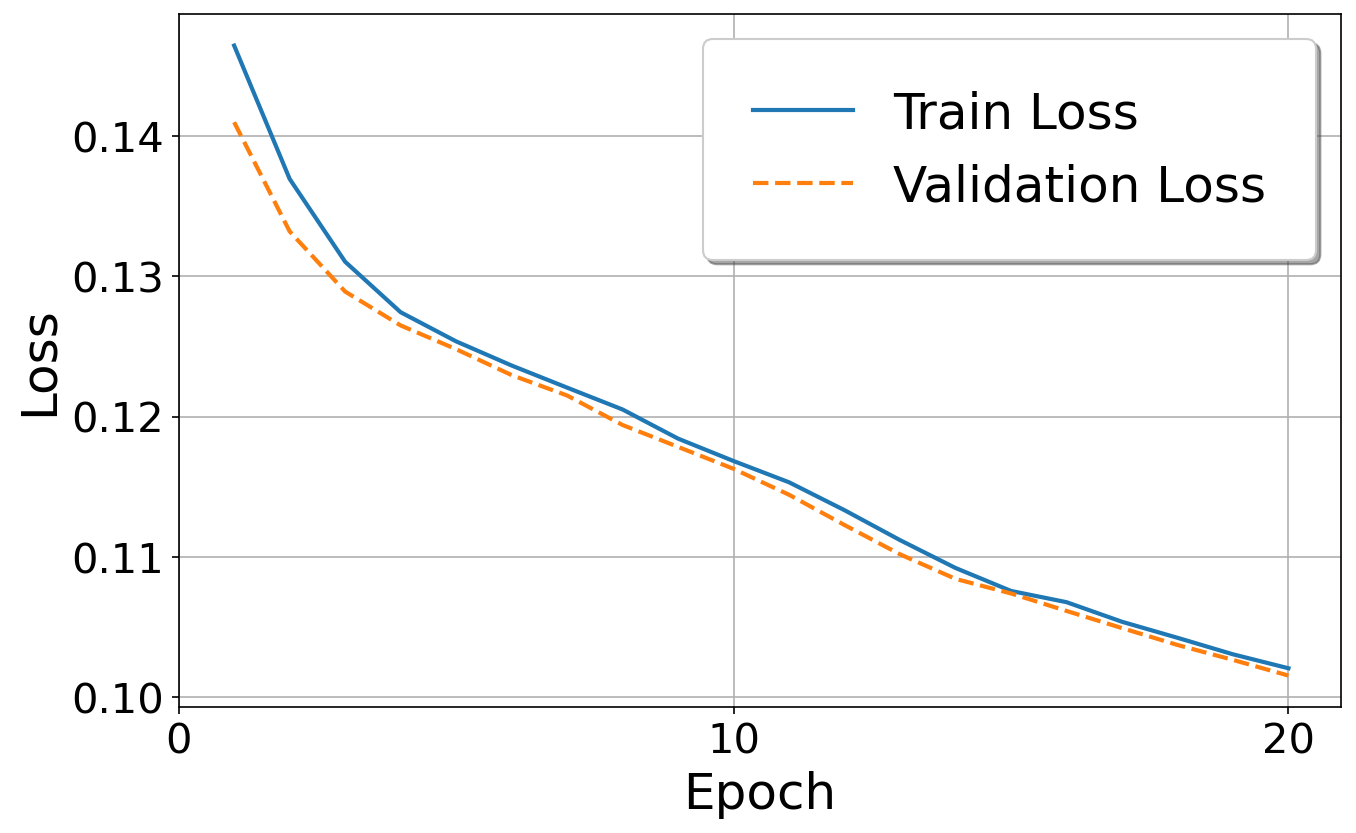

In [ ]:
def_metric_dir = path.join("definitive_model/metrics/csv")

#loss_plots
loss_train_df = pd.read_csv(def_metric_dir.join("train_loss.csv"))
loss_train_df = loss_train_df.set_index("epoch")

loss_val_df = pd.read_csv(def_metric_dir.join("val_loss.csv"))
loss_val_df = loss_val_df.set_index("epoch")

plot_loss(loss_train_df, loss_val_df,10)


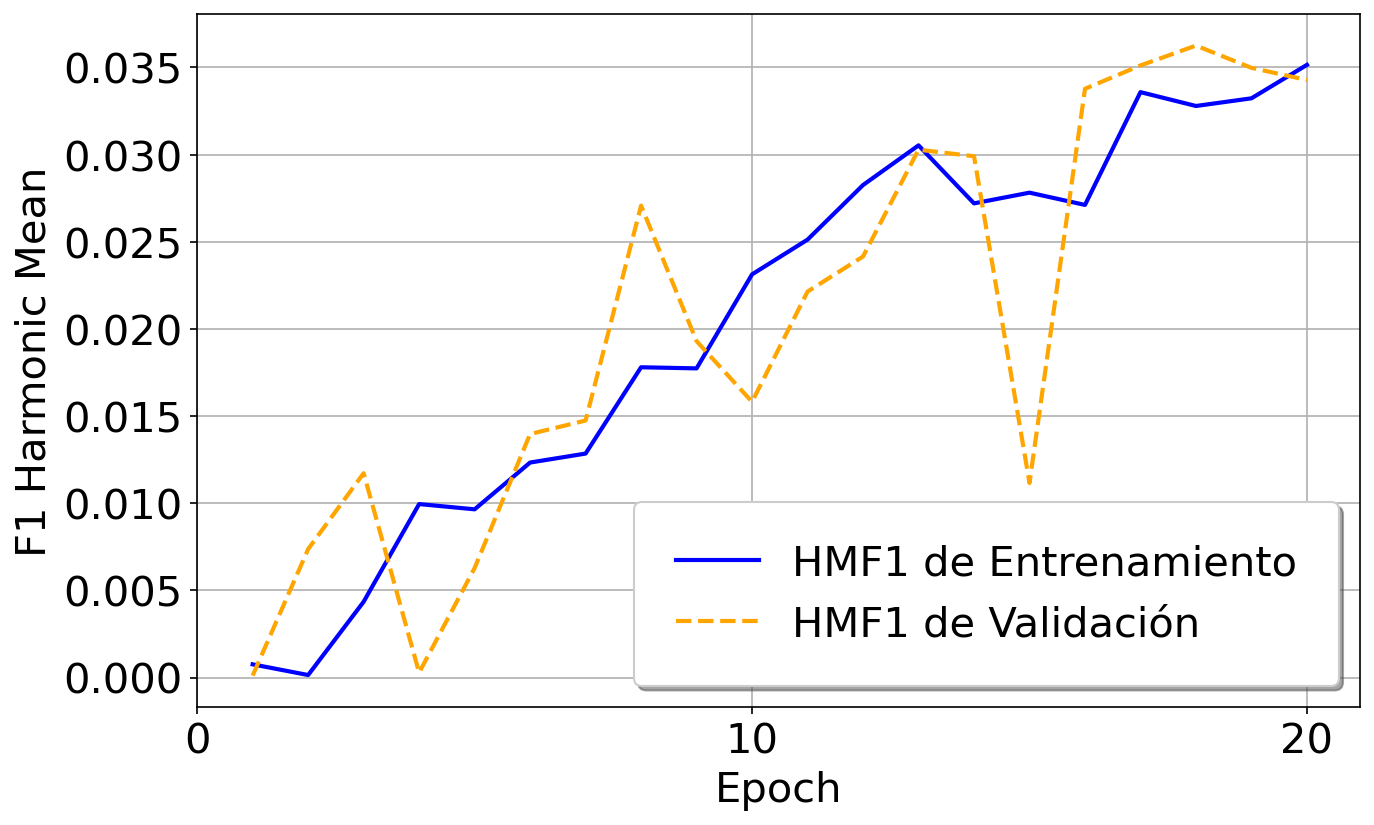

In [ ]:
dmg_train_df = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_harmonic_mean(dmg_train_df, dmg_val_df,10)

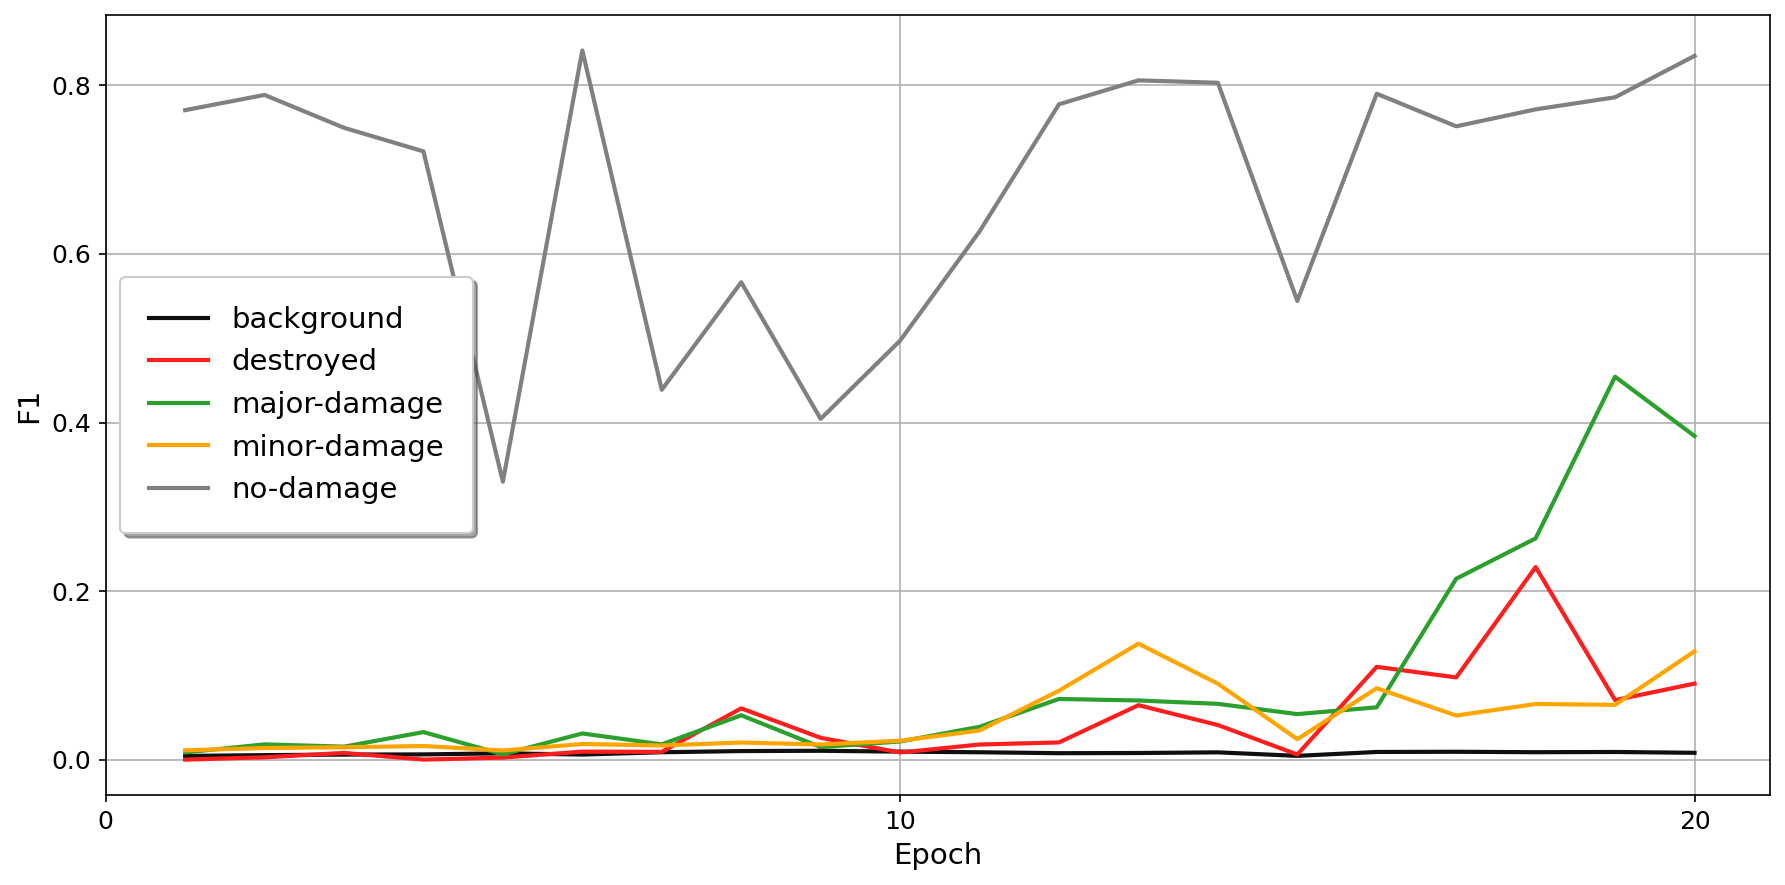

In [ ]:
#val_f1_plots
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))
plot_metric_per_class(dmg_val_df, "f1",10)
